<a href="https://colab.research.google.com/github/ashhwiithac22/Deep-Learning-Experiments/blob/main/DL_Ex4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:03<00:00, 47.1MB/s]


Training without augmentation:
Epoch 1, Accuracy: 0.4525
Epoch 2, Accuracy: 0.5705
Epoch 3, Accuracy: 0.6162
Epoch 4, Accuracy: 0.6423
Epoch 5, Accuracy: 0.6691

Training with augmentation:
Epoch 1, Accuracy: 0.3200
Epoch 2, Accuracy: 0.4192
Epoch 3, Accuracy: 0.4547
Epoch 4, Accuracy: 0.4758
Epoch 5, Accuracy: 0.4904


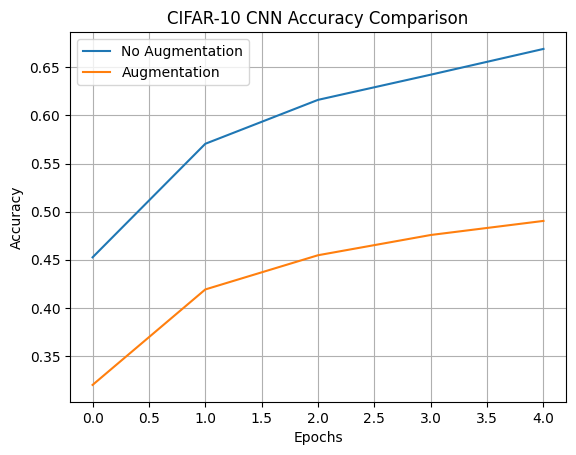

In [ ]:
#without augmentation - model is trained using original images without any modifications (the model may memorize, can overfit)
#with augmentation - model is trained using modified versions of the image
import torch
import torch.nn as nn #used to create neural netrworks
import torch.optim as optim #used to update model weights during training
import torchvision #provide image dataset such as CIFAR
import torchvision.transforms as transforms #used for data augmentation
from torchvision.transforms import functional as F #used for gaussian blur
import matplotlib.pyplot as plt

transform_no_aug = transforms.ToTensor() #converts the image into tensor(number) format

#modifies images before training
transform_aug = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate=(0.2,0.2), scale=(0.8,1.2)), #rotates image between -20degree to +20degree, moves image left,right, up or down by 20%of image, zooms in or out between 80% and 120%
    transforms.ToTensor(), #coverts image to tensor format (pixel values betweeen 0 and 1)
    transforms.Lambda(lambda img: torch.clamp(img + 0.15, 0, 1)), #adds 0.15 to each pixel, makes image brighter
    transforms.Lambda(lambda img: torch.clamp(img + (img - F.gaussian_blur(img,3)), 0, 1)) #highlights edges by subtracting the blurred image from the original
])


train_no_aug = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_no_aug) #loads CIFAR-10 dataset without augmentation
train_aug = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_aug) #loads CIFAR-10 dataset with augmentation
test = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_no_aug) #uses test data and not training data and data without augmentation

loader_no_aug = torch.utils.data.DataLoader(train_no_aug, batch_size=128, shuffle=True)
loader_aug = torch.utils.data.DataLoader(train_aug, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=128)


class CNN(nn.Module): #creates a neural network model
    def __init__(self): #constructor
        super().__init__()
        self.c1 = nn.Conv2d(3,32,3,padding=1) #first convolutional layer, 3 input channels, 32 output channels, 3*3 pixels 1 -> keeps the image size same
        self.c2 = nn.Conv2d(32,64,3,padding=1) #32input channels (from previous layer), 64 output channels , 3*3 pixels
        self.fc = nn.Linear(64*8*8,10) #4096 is the number of neurons and the 10 is classes

    def forward(self,x): #forward pass of the CNN
        x = torch.relu(self.c1(x)) #r1st convolutional layer, relu - rectified linear unit
        x = torch.max_pool2d(x,2) #reduces height and width by half
        x = torch.relu(self.c2(x))
        x = torch.max_pool2d(x,2)
        x = x.view(x.size(0),-1) #coverts 3D into 1D
        return self.fc(x)


def train(loader, epochs=5): #epochs -> the number of times the network will see the entire dataset
    model = CNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #updates the model weights to reduce errors, lr = learning rate
    loss_fn = nn.CrossEntropyLoss() #loss function calculates how wrong the model is
    acc = [] #stores accuracy

    for epoch in range(epochs):
        correct = total = 0
        for x, y in loader:
            optimizer.zero_grad() #clears previous gradients
            output = model(x) #forward pass
            loss = loss_fn(output, y) #compute loss
            loss.backward() #back propagation
            optimizer.step() #updates the weights
            correct += (output.argmax(1)==y).sum().item() #Count how many images in this batch the model predicted correctly and add it to the total
            total += y.size(0)

        epoch_acc = correct/total #compute accuracy
        acc.append(epoch_acc) #save accuracy
        print(f"Epoch {epoch+1}, Accuracy: {epoch_acc:.4f}")  #Prints the epoch number and its accuracy

    return acc

print("Training without augmentation:")
acc_no_aug = train(loader_no_aug)

print("\nTraining with augmentation:")
acc_aug = train(loader_aug)

plt.plot(acc_no_aug,label="No Augmentation")
plt.plot(acc_aug,label="Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-10 CNN Accuracy Comparison")
plt.legend()
plt.grid()
plt.show()
